### Import Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
import librosa
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.layers import Bidirectional, TimeDistributed, Conv2D, MaxPooling2D, Input, GRU, Dense, Activation, Dropout, Reshape, Permute, MaxPooling1D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
batch=[]
batch.append(500)
batch.append(500)
batch.append(32)

### Define Models

In [ ]:
# defining models as functions

clf=[[],[],[]]
callbacks=[]
opt=[]
### MODEL1: CRNN ###
print("Model 1: Convolution Recurrent Neural Network (CRNN)")
opt.append(keras.optimizers.Adam(learning_rate=0.001))
def clf0():
  seq = keras.Sequential(
      [
          layers.Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape=(16,8,1) ),
          layers.MaxPool2D(pool_size=(2, 2)),
          layers.Conv2D(128, (3, 3), padding = "same", activation = "tanh"),
          layers.MaxPool2D(pool_size=(2, 2)),
          layers.Reshape((8, 128)),
          layers.LSTM(32),
          layers.Flatten(),
          layers.Dense(32),
          layers.Dropout(0.2),
          layers.Dense(10, activation='softmax'),
      ]
  )
  seq.compile(loss="categorical_crossentropy", optimizer=opt[0], metrics=['accuracy'])
  return seq
callbacks.append([ModelCheckpoint('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/CRNN_80.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 40,restore_best_weights = True)])
print(clf0().summary())

### MODEL2: LSTM ###
print('Model 2: Long Short Term Memory (LSTM)')
opt.append(Adam(lr=0.001))
def clf1():
  input_dim = (16, 8)
  dropout=0.1
  n_classes=10
  learning_rate = 0.001

  model = Sequential()
  model.add(LSTM(256, return_sequences=True, input_shape=input_dim,dropout=dropout))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt[1],metrics=['accuracy'])
  return model
callbacks.append([ModelCheckpoint('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/LSTM_80.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 40,restore_best_weights = True)])
print(clf1().summary())

### Model3 MLP ###
print('Model 3:Multi-Layer Perceptron (MLP)')
opt.append(Adam(lr=0.001))
def clf2():
  input_dim = (128,)
  dropout=0.1
  n_classes=10
  learning_rate = 0.001
  num_classes = 10

  model = Sequential()

  model.add(Dense(256, input_shape=input_dim ))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt[2],metrics=['accuracy'])
  return model
callbacks.append([ModelCheckpoint('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/MLP_80.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 40,restore_best_weights = True)])
print(clf2().summary())

Model 1: Convolution Recurrent Neural Network (CRNN)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 128)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                20608     
_________________________________________________________________
f

### Load extracted features

In [ ]:
# importing data
X=np.load('/content/drive/MyDrive/ML_A/Tri train/X_normalized.npy')
y=np.load('/content/drive/MyDrive/ML_A/Tri train/y_normalized.npy')

In [ ]:
## Splitting the data into 60% unlabeled 10% testing and 30% training
X__train, X_un, y__train, y_un = train_test_split(X, y, test_size=0.6,random_state=1)
X_label, X_test, y_label, y_test = train_test_split(X__train, y__train, test_size=0.25,random_state=1)

In [ ]:
# converting shape of data for each model
X_label_data = [X_label.reshape(len(X_label), 16, 8, 1), X_label.reshape(len(X_label), 16, 8), X_label.reshape(len(X_label), 128)]
X_un_data = [X_un.reshape(len(X_un), 16, 8, 1), X_un.reshape(len(X_un), 16, 8), X_un.reshape(len(X_un), 128)]

### Tri training with majority

In [ ]:
iteration = 0
val_acc = [[], [], []]
train_acc = [[], [], []]
num_labled = []
num_unlabled = []
test_acc = []
pseudo_labels_acc=[]  # percentage correct of pseudo labels
labels_added=[]
threshold = 0.95

In [ ]:
# tri training

while iteration<6:
  print(iteration)
  y_pred = []
  # Step 1: Create the model and fit for newly labeled data at each iteration
  for i in range(3):                          # training models
    if iteration == 0:
      X_resample, y_resample = sklearn.utils.resample(X_label_data[i], y_label) # Bootstrap sample to give different data to each model in first iteration 
    else:
      X_resample = X_label_data[i]
      y_resample = y_label

    X_train, X_val, y_train, y_val = train_test_split(X_resample, y_resample, test_size=0.25)

    # Create the model
    if i==0:
      clf[i]=clf0()
    elif i==1:
      clf[i]=clf1()
    else: clf[i]=clf2()
    print('model', i)
    
    # Fit on newly labeled data
    clf[i].fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 300, batch_size = batch[i], shuffle=True, callbacks=callbacks[i])
    
    # Predict on unlabeled data
    y_pred.append(clf[i].predict(X_un_data[i]))

    # Calculate traning accuracy
    y_predict = np.argmax(clf[i].predict(X_train), axis=1)
    p = 0
    for j in range(len(y_predict)):
      if y_predict[j]==np.argmax(y_train[j]): p+=1
    train_acc[i].append(p/len(y_predict))

    # Calculate validation accuracy
    y_predict = np.argmax(clf[i].predict(X_val), axis=1)
    p = 0
    for j in range(len(y_predict)):
      if y_predict[j]==np.argmax(y_val[j]): p+=1
    val_acc[i].append(p/len(y_predict))
  
  # Step 2: Calculate Testing  Accuracy
  y_pred0 = clf[0].predict(X_test.reshape(len(X_test), 16, 8, 1))
  y_pred1 = clf[1].predict(X_test.reshape(len(X_test), 16, 8))
  y_pred2 = clf[2].predict(X_test.reshape(len(X_test),128))
  
  # Use mean probabilty to decide class
  y_sum = y_pred0 + y_pred1 + y_pred2
  y_sum = np.argmax(y_sum, axis=1)
  p = 0
  for i in range(len(y_sum)):
    if y_sum[i]==np.argmax(y_test[i]): p+=1
  test_acc.append(p/len(y_sum))

  # Initial labeled and unlabeled data
  index_to_be_added = []
  num_labled.append(len(X_label_data[0]))
  num_unlabled.append(len(X_un_data[0]))

  # Step 3: Create pseudo labeled data
  pseudo_acc = 0
  # Iterate on each example of unlabeled data
  for i in range(len(y_pred[0])):           
    yes = 0                                               # yes: 1 if example comsidered as pseudo label otherwise 0
    y_pred_new = -1                                       # y_pred_new: holds the label of pseudo label data
    y_m0 = np.argmax(y_pred[0][i])                        # y_m0,y_m1,y_m2: holds the classes predicted for ith example by 0th,1st,and 2md model respectively
    y_m1 = np.argmax(y_pred[1][i])
    y_m2 = np.argmax(y_pred[2][i])
    p_m0 = y_pred[0][i][y_m0]/np.sum(y_pred[0][i])        # p_m0,p_m1,p_m2: hold the class proba
    p_m1 = y_pred[1][i][y_m1]/np.sum(y_pred[1][i])
    p_m2 = y_pred[2][i][y_m2]/np.sum(y_pred[2][i])
    p_max = max(max(p_m1, p_m2), p_m0)

    # Necessary Conditions for pseudo label to be added through majority voting: Any two of three models prediction must be greater than threshold
    if y_m0==y_m1 and p_m0>=threshold and p_m1>=threshold:
      yes = 1
      y_pred_new = y_m0
      index_to_be_added.append(i)

    elif y_m2==y_m1 and p_m2>=threshold and p_m1>=threshold:
      yes = 1
      y_pred_new = y_m1
      index_to_be_added.append(i)

    elif y_m0==y_m2 and p_m0>=threshold and p_m1>=threshold:
      yes = 1
      y_pred_new = y_m0
      index_to_be_added.append(i)
    
      
     # Update the labeled data
    if yes==1:            
      for j in range(3):
        X_label_data[j] = np.append(X_label_data[j],np.array([X_un_data[j][i]]),axis=0)
      y_label = np.append(y_label, np.array(to_categorical([y_pred_new], num_classes=10)), axis=0)
      if y_pred_new == np.argmax(y_un[i]): pseudo_acc+=1   # calculate the percentage of correct pseudo label

  if len(index_to_be_added)==0: break

  # delete the pseudo labels from unlabeled
  for i in range(3):
    X_un_data[i] = np.delete(X_un_data[i], index_to_be_added, 0)

  y_un = np.delete(y_un, index_to_be_added, 0)
  labels_added.append(len(index_to_be_added))
  pseudo_labels_acc.append(pseudo_acc*100/len(index_to_be_added))
  iteration+=1
    
    

0
model 0
Epoch 1/300
4/4 [==============================] - 3s 357ms/step - loss: 2.2854 - accuracy: 0.1028 - val_loss: 2.2248 - val_accuracy: 0.1313
Epoch 2/300
4/4 [==============================] - 1s 204ms/step - loss: 2.2104 - accuracy: 0.1364 - val_loss: 2.1240 - val_accuracy: 0.1893
Epoch 3/300
4/4 [==============================] - 1s 205ms/step - loss: 2.1146 - accuracy: 0.2099 - val_loss: 2.0836 - val_accuracy: 0.2290
Epoch 4/300
4/4 [==============================] - 1s 202ms/step - loss: 2.1333 - accuracy: 0.2007 - val_loss: 2.0511 - val_accuracy: 0.2580
Epoch 5/300
4/4 [==============================] - 1s 200ms/step - loss: 2.0479 - accuracy: 0.2403 - val_loss: 2.0147 - val_accuracy: 0.2397
Epoch 6/300
4/4 [==============================] - 1s 200ms/step - loss: 2.0239 - accuracy: 0.2476 - val_loss: 2.0024 - val_accuracy: 0.2382
Epoch 7/300
4/4 [==============================] - 1s 201ms/step - loss: 1.9818 - accuracy: 0.2665 - val_loss: 1.9302 - val_accuracy: 0.2748
Epo

In [ ]:
result = pd.DataFrame()
result['num_labled']=num_labled
result['num_unlabled']=num_unlabled
result['labels_added']=labels_added
result['train_acc_CRNN']=train_acc[0]
result['val_acc_CRNN']=val_acc[0]
result['train_acc_LSTM']=train_acc[1]
result['val_acc_LSTM']=val_acc[1]
result['train_acc_MLP']=train_acc[2]
result['val_acc_MLP']=val_acc[2]
result['pseudo_labels_acc']=pseudo_labels_acc
result['test_acc']=test_acc

In [ ]:
result.to_csv("/content/drive/MyDrive/ML_A/Tri train/result.csv")

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/ML_A/Tri train/result.csv')

In [ ]:
result

,num_labled,num_unlabled,labels_added,train_acc_CRNN,val_acc_CRNN,train_acc_LSTM,val_acc_LSTM,train_acc_MLP,val_acc_MLP,pseudo_labels_acc,test_acc
0,2619,5240,2526,0.883910,0.745038,0.997963,0.862595,0.968432,0.812214,92.201108,0.743414
1,5145,2714,373,0.917315,0.790210,0.973561,0.860140,0.948678,0.815851,83.378016,0.751432
2,5518,2341,223,0.935476,0.823188,0.990092,0.861594,0.930159,0.821739,85.650224,0.764032
3,5741,2118,85,0.887340,0.791086,0.987224,0.873955,0.946109,0.841922,82.352941,0.746850
4,5826,2033,160,0.942321,0.827728,0.982376,0.868222,0.959030,0.855182,78.125000,0.758305
5,5986,1873,90,0.953665,0.828991,0.970372,0.857047,0.945645,0.825651,67.777778,0.761741


### Confusion Matrix

In [ ]:
m1 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/CRNN_80.h5')  
m2 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/MLP_80.h5') 
m3 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/LSTM_80.h5')  
y1 = m1.predict(X_test.reshape(len(X_test), 16,8,1))
y2 = m2.predict(X_test.reshape(len(X_test), 128))
y3 = m3.predict(X_test.reshape(len(X_test), 16,8))
y_total_pred=[]

y = []
for k in range(len(y1)):
  p_1 = y1[k][np.argmax(y1[k])]
  p_2 = y2[k][np.argmax(y2[k])]
  p_3 = y3[k][np.argmax(y3[k])]
  p_max = max(max(p_1, p_2), p_3)
  if np.argmax(y1[k])==np.argmax(y2[k]) and (p_1>=0.85 or p_2>=0.85):
    y.append(y1[k])
  elif np.argmax(y2[k])==np.argmax(y3[k]) and (p_2>=0.85 or p_3>=0.85):
    y.append(y2[k])
  elif np.argmax(y3[k])==np.argmax(y1[k]) and (p_3>=0.85 or p_1>=0.85):
    y.append(y3[k])
  else:
    if p_max==p_1:
      y.append(y1[k])
    elif p_max==p_2:
      y.append(y2[k])
    elif p_max==p_3:
      y.append(y3[k])


y = np.argmax(y, axis=1)
y_total_pred=y_total_pred+y.tolist()
############################################## Getting no. of correct prediction########################
sum=0
#y=np.load('/content/drive/MyDrive/ML_N/Real_time_data/y.npy')
for i in range(len(y_total_pred)):
#  print(y_pred[i],y[i])
  if y_total_pred[i]==np.argmax(y_test[i]):
    sum=sum+1


In [ ]:
from sklearn.metrics import confusion_matrix

label=[ 'air_conditioner', 'car_horn', 'children_playing','dog_bark', 'drilling', 'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
cm = confusion_matrix(np.argmax(y_test, axis=1), y_total_pred, [0,1,2,3,4,5,6,7,8,9])

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix of Tri-training', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/ML_A/tri train_majority vote.png')
    plt.show()

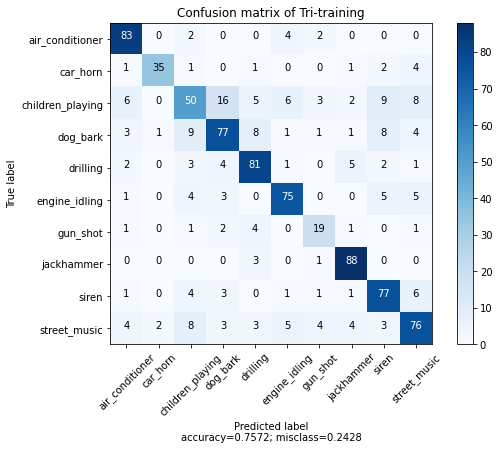

In [ ]:
plot_confusion_matrix(cm, label, normalize=False)